Pipeline is generally laid out as sequential steps and this is not a coincidence. Generally, feature extractor, feature selector and classifiers are applied in a consecutive manner for a supervised learning problem. In feature extraction, some may want to first extract bag-of-words then weight by Tf-Idf to improve the feature extractor. However, there could be also cases that some may want to __concatenate__ the features rather than applying as sequential steps. 

`FeatureUnion` class aims to solve this problem. You could combine different feature extractor outputs independently into a single feature matrix and then use it. This is quite useful for a number of reasons; first it works just like `pipeline`, you could give a tuple where one of the arguments is estimator name and other estimator itself. Second, the object could be used as a step in the `pipeline`, so it is very easy to use. Third, it allows you to experiment different feature extractor methods and possbily use them if you have a good feature selector method. Last but not least, it allows you to abstract the feature extraction step in a single step even if the features you aggregate could vary a lot. It does multiple feature extraction operations in parallel, so if you have multi-cores, you are in luck in terms of processing time.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn import cross_validation
from sklearn import decomposition
from sklearn import ensemble
from sklearn import feature_selection
from sklearn import linear_model
from sklearn import pipeline
from sklearn import preprocessing

DATA_DIR = 'data'
BANK_DIR = os.path.join(DATA_DIR, 'bank')
BANK_FULL_PATH = os.path.join(BANK_DIR, 'bank-full.csv')
EXPLANATION_PATH = os.path.join(BANK_DIR, 'bank-names.txt')

C:\Users\mkangrga\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
with open(EXPLANATION_PATH) as f:
    explanation = f.readlines()
explanation = '\n'.join(explanation)    

In [5]:
print(explanation)

Citation Request:

  This dataset is public available for research. The details are described in [Moro et al., 2011]. 

  Please include this citation if you plan to use this database:



  [Moro et al., 2011] S. Moro, R. Laureano and P. Cortez. Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology. 

  In P. Novais et al. (Eds.), Proceedings of the European Simulation and Modelling Conference - ESM'2011, pp. 117-121, GuimarÃ£es, Portugal, October, 2011. EUROSIS.



  Available at: [pdf] http://hdl.handle.net/1822/14838

                [bib] http://www3.dsi.uminho.pt/pcortez/bib/2011-esm-1.txt



1. Title: Bank Marketing



2. Sources

   Created by: Paulo Cortez (Univ. Minho) and SÃ©rgio Moro (ISCTE-IUL) @ 2012

   

3. Past Usage:



  The full dataset was described and analyzed in:



  S. Moro, R. Laureano and P. Cortez. Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology. 

  In P. Novais et al. (Eds.), Proceed

In [6]:
df = pd.read_csv(BANK_FULL_PATH, delimiter=';')
df.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


### Let's conver the categorical variables 

In [7]:
label_encoder = preprocessing.LabelEncoder()
for field in ('job', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'marital'):
    df[field] = label_encoder.fit_transform(df[field])

In [11]:
y = df.y
del df['y']

In [13]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,58,4,1,2,0,2143,1,0,2,5,8,261,1,-1,0,3
1,44,9,2,1,0,29,1,0,2,5,8,151,1,-1,0,3
2,33,2,1,1,0,2,1,1,2,5,8,76,1,-1,0,3
3,47,1,1,3,0,1506,1,0,2,5,8,92,1,-1,0,3
4,33,11,2,3,0,1,0,0,2,5,8,198,1,-1,0,3


The variables are all numeric but they differ in terms of quantity, let's normalize them.

### Normalization of Features

In [14]:
standard_scaler = preprocessing.StandardScaler()

In [15]:
for field in df.columns:
    df[field] = standard_scaler.fit_transform(df[field])

C:\Users\mkangrga\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
C:\Users\mkangrga\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\mkangrga\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(D

In [16]:
X = df.as_matrix()
print(X.shape, y.shape)

(45211, 16) (45211,)


In [17]:
feature_correlations = np.dot(X.T, X)
feature_correlations /= np.max(feature_correlations)

In [18]:
feature_correlations_df = pd.DataFrame.from_records(feature_correlations, columns=df.columns)

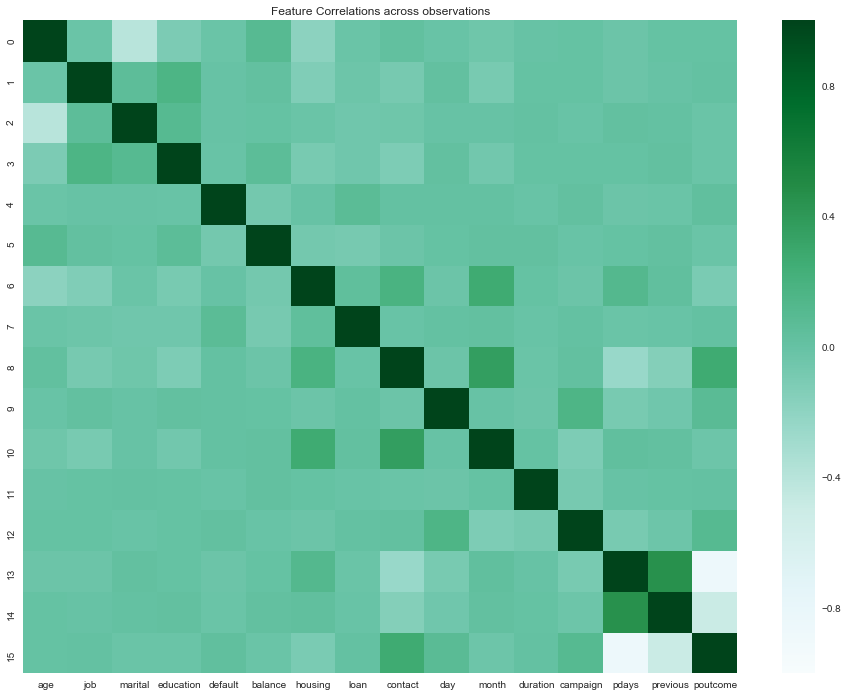

In [19]:
plt.figure(figsize=(16, 12))
sns.heatmap(feature_correlations_df, cmap="BuGn");
plt.title('Feature Correlations across observations');

We could take a look at how the fature are correlated to each other. Some of the fatures are somehow correlated(`age`, `job`, `marital`, `education`), PCA could be used an efficient feature extraction method to remove the correlations in the dataset and 
choose the eigenvectors that capture the most of the information. We could also use the best `k` features using `feature_selection` submodule in scikit-learn to improve the feature extraction a little bit better. Lastly, feature union accepts a number of steps to parallelize and accepts a `n_jobs` parameter to parallelize the feature extraction methods. 

In [22]:
pca = decomposition.PCA(n_components=2)
k_best_selection = feature_selection.SelectKBest(k=10)
#kernel_pca = decomposition.KernelPCA(n_components=3)
feature_union = pipeline.FeatureUnion([("pca", pca), 
                                       ("k_best_selection", k_best_selection), 
                                       #("kernel_pca", kernel_pca)
                                      ], 
                                      n_jobs=4)

In [23]:
feature_union

FeatureUnion(n_jobs=4,
       transformer_list=[('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('k_best_selection', SelectKBest(k=10, score_func=<function f_classif at 0x000000000B53E378>))],
       transformer_weights=None)

In [24]:
feature_union = feature_union.fit(X, y)

In [25]:
features = feature_union.transform(X)

In [26]:
features

array([[-0.78901204, -1.31618434,  1.03636182, ..., -0.41145311,
        -0.25194037,  0.44489814],
       [-0.73083889, -1.27888775, -0.30055587, ..., -0.41145311,
        -0.25194037,  0.44489814],
       [-0.8287255 , -2.38481196, -0.30055587, ..., -0.41145311,
        -0.25194037,  0.44489814],
       ..., 
       [ 1.57856345,  0.58289744, -0.30055587, ...,  1.43618859,
         1.05047333, -0.56617504],
       [-0.94370403, -0.4081311 , -0.30055587, ..., -0.41145311,
        -0.25194037,  0.44489814],
       [ 3.93429277, -0.31493114, -0.30055587, ...,  1.4761376 ,
         4.52357654, -1.57724822]])

In [18]:
selected_feature_correlations = np.dot(features.T, features)
selected_feature_correlations /= np.max(selected_feature_correlations)

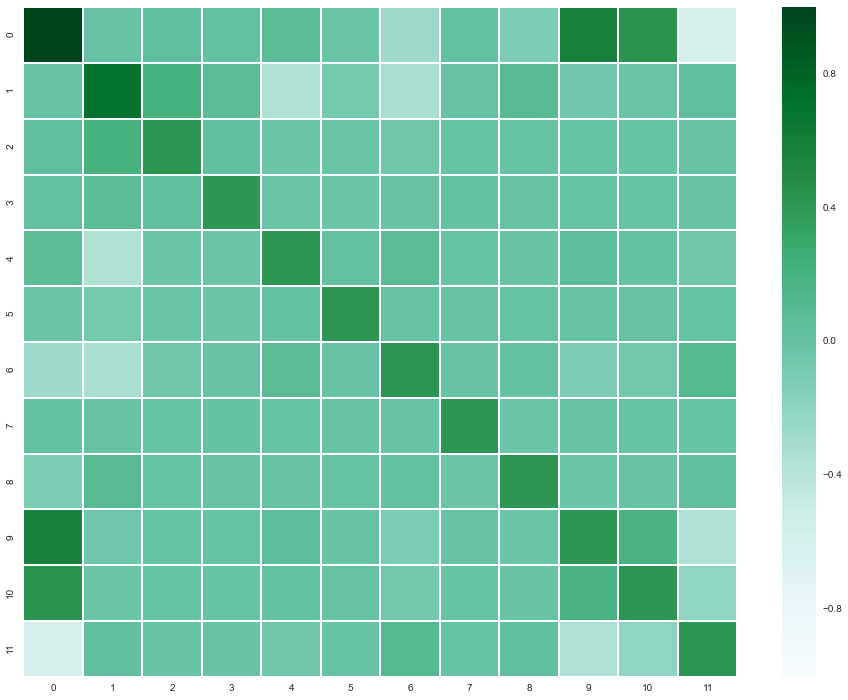

In [19]:
plt.figure(figsize=(16, 12))
sns.heatmap(selected_feature_correlations, cmap="BuGn");

In [20]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=.25, random_state=1)

In [21]:
features_train, features_test, y_train, y_test = cross_validation.train_test_split(features, y, test_size=.25, random_state=1)

In [22]:
clf = linear_model.LogisticRegression(C=100, fit_intercept=True)
clf = ensemble.AdaBoostClassifier(n_estimators=1000)
clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=1000, random_state=None)

In [23]:
clf.score(X_test, y_test)

0.90011501371317348

In [24]:
clf.fit(features_train, y_train)
clf.score(features_test, y_test)

0.90126515084490844

This is not guaranteed to always perform better than the original classifier, but it is very easy to apply different feature extraction methods on the raw dataset and possibly parallelize this feature extraction as well. After extracting the features, 
you could easily concatenate the results and feed to your favorite classifier. As the feature extraction methods are separately operate on the dataset and as long as you have multi-core machine, you could easily give `n_jobs` to number of your cores in your machine to parallelize the feature extraction method so that you do not have to wait the total time it takes to run all of the feature extraction but only the one that takes the most computation time. 

Since the feature extraction or engineering is one of the most important thing for how successful a machine learning system performs, feature unions provide a broader selection of features to be chosen and also to be used by the classifier. The more is not always the better, but we could always choose best `k` features on top of those and possibly build a better feature set than using a particular feature set.